{% include toc title = "In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this tutorial, you will be able to:

* Identify co-occurring words (i.e. bigrams) in Tweets.
* Create networks of words in Tweets.  

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson.

</div>

## Get and Clean Tweets Related to Climate

In the previous lesson, you learned how to collect and clean data that you collected using `Tweepy` and the Twitter API. Begin by reviewing how to authenticate to the Twitter API and how to search for tweets.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

Remember to define your keys: 

```python 
consumer_key= 'yourkeyhere'
consumer_secret= 'yourkeyhere'
access_token= 'yourkeyhere'
access_token_secret= 'yourkeyhere'
```

In [2]:
consumer_key = os.environ['tw_consumer_key']
consumer_secret = os.environ['tw_consumer_secret']
access_token = os.environ['tw_access_token']
access_token_secret = os.environ['tw_access_secret']

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [4]:
# Create a custom search term and define the number of tweets
search_term = "#climate+change -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2018-11-01').items(1000)

Next, grab and clean up 1000 recent tweets. For this analysis, you need to remove URLs, lower case the words, and remove stop and collection words from the tweets. 

In [5]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

In [6]:
# Remove URLs
tweets_no_urls = [remove_url(tweet.text) for tweet in tweets]

# Create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
collection_words = ['climatechange', 'climate', 'change']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leahwasser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Explore Co-occurring Words (Bigrams)

To identify co-occurrence of words in the tweets, you can use `bigrams` from `nltk`. 

Begin with a list comprehension to create a list of all bigrams (i.e. co-occurring words) in the tweets. 

In [7]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# View bigrams for the first tweet
terms_bigram[0]

[('going', 'forward'),
 ('forward', 'starting'),
 ('starting', 'right'),
 ('right', 'need'),
 ('need', 'double'),
 ('double', 'sustainability'),
 ('sustainability', 'need'),
 ('need', 'unapologetically'),
 ('unapologetically', 'talk'),
 ('talk', 'ab')]

Notice that the words are paired by co-occurrence. You can remind yourself of the original tweet or the cleaned list of words to see how co-occurrence is identified.  

In [8]:
# Original tweet without URLs
tweets_no_urls[0]

'science Links to articles about science and climate change climate greenenergy progressive future'

In [9]:
# Clean tweet 
tweets_nsw_nc[0]

['science',
 'links',
 'articles',
 'science',
 'greenenergy',
 'progressive',
 'future']

Similar to what you learned in the previous lesson on word frequency counts, you can use a counter to capture the bigrams as dictionary keys and their counts are as dictionary values. 

Begin by flattening the list of bigrams. You can then create the counter and query the top 20 most common bigrams across the tweets. 

In [10]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('live', 'cop24'), 11),
 (('climateaction', 'climatechangeisreal'), 9),
 (('climatechangeisreal', 'poetry'), 9),
 (('poetry', 'poem'), 9),
 (('key', 'scientific'), 9),
 (('cop24', 'fails'), 9),
 (('fails', 'adopt'), 9),
 (('adopt', 'key'), 9),
 (('side', 'event'), 9),
 (('scientific', 'report'), 8),
 (('gpwx', 'globalwarming'), 7),
 (('32', 'trillion'), 7),
 (('global', 'reach'), 7),
 (('saudi', 'arabia'), 6),
 (('global', 'warming'), 6),
 (('investors', 'managing'), 6),
 (('trillion', 'assets'), 6),
 (('assets', 'call'), 6),
 (('call', 'action'), 6),
 (('cop24', 'unfccc'), 6)]

Once again, you can create a `Pandas Dataframe` from the counter. 

In [11]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(live, cop24)",11
1,"(climateaction, climatechangeisreal)",9
2,"(climatechangeisreal, poetry)",9
3,"(poetry, poem)",9
4,"(key, scientific)",9
5,"(cop24, fails)",9
6,"(fails, adopt)",9
7,"(adopt, key)",9
8,"(side, event)",9
9,"(scientific, report)",8


## Visualize Networks of Bigrams

You can now use this `Pandas Dataframe` to visualize the top 20 occurring bigrams as networks using the `Python` package `NetworkX`.

In [12]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

In [13]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("china", weight=100)

#G.add_weighted_edges_from([(k[0], k[1], v*10)], weight=v*10)
    
#https://www.kaggle.com/jncharon/python-network-graph/notebook

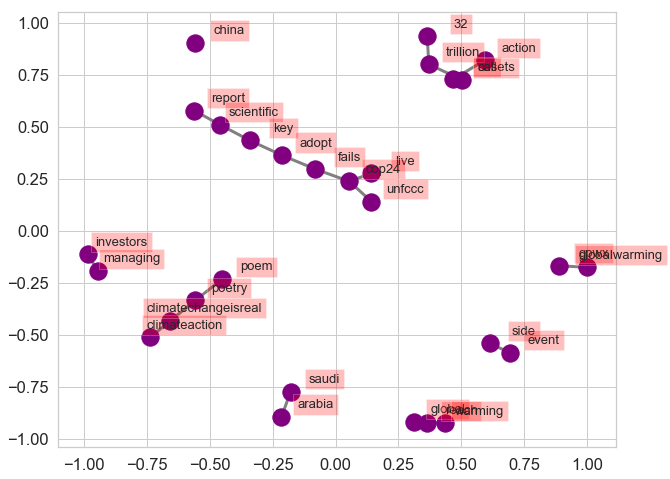

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()